# Introduction
This is the random forest learner associated with Voter Analysis.
Please be sure to run DataCleaning.ipynb first to prepare the data

## Imports
Import libraries and write settings here.

In [1]:
from fastai.tabular import *
from fastai import *

# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 60
pd.options.display.max_rows = 60

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(theme='white')



# Load train/test and catagorical and continuous column names
If either of the following fail then please be sure to run DataCleaning.ipynb first to prepare the data

In [2]:
trn = pd.read_feather('tmp/train')
tst = pd.read_feather('tmp/tst')

In [3]:
with open('tmp/catcont.json') as f:
    data1 = json.load(f)

    res_cont = data1[0]
    res_cat = data1[1] 
    columns_dep_var = data1[2][0]
    
# res_cont
# res_cat

In [4]:
#remove the dependant variable
res_cont = [x for x in res_cont if x not in columns_dep_var]
res_cat = [x for x in res_cat if x not in columns_dep_var]

In [5]:
#convert trumpgevote to long (otherwise fit fails)
trn[columns_dep_var] = trn[columns_dep_var].astype('int64');
tst[columns_dep_var] = tst[columns_dep_var].astype('int64');

print(str(len(trn)))
print(str(len(tst)))

36801
4089


## Categorify and Fill Missing

In [6]:
#from docs https://docs.fast.ai/tabular.transform.html
tfm = Categorify(cat_names=res_cat, cont_names=res_cont)
tfm(trn)
tfm(tst)

In [7]:
#just checking to see if it works on any old variable
trn[res_cat[0]].cat.categories
tst[res_cat[0]].cat.categories

Int64Index([0, 1], dtype='int64')

Int64Index([0, 1], dtype='int64')

In [8]:
tfm1 = FillMissing(cat_names=res_cat, cont_names=res_cont)
tfm1(trn)
tfm1(tst)

## Clean up any missing columns that result from unfortunate test selection

In [9]:
trn_y=trn[columns_dep_var].copy()
trn=trn.drop(columns_dep_var,axis=1)

tst_y=tst[columns_dep_var].copy()
tst=tst.drop(columns_dep_var,axis=1)

# trn.T
# trn_y

In [10]:
#You cannot have any Nan (missing data) fields or random forest will not work.
print(f"Total trn columns = {len(trn.columns)}, total tst columns = {len(tst.columns)}") 
print(f"Total trn columns with Nans= {len(trn.columns[trn.isnull().any()])}") #add ~ to get columns with no missing values
print(f"Total tst columns with Nans= {len(tst.columns[tst.isnull().any()])}") #add ~ to get columns with no missing values

Total trn columns = 53, total tst columns = 52
Total trn columns with Nans= 0
Total tst columns with Nans= 0


In [11]:
#hmmm if either has 1 more column than train then see what it is
set(tst.columns)-set(trn.columns)
set(trn.columns)-set(tst.columns)

set()

{'cc.catholic_na'}

In [12]:
#missing one of the _na columns.  This is added, and set to 1, when a variable has an NaN value to mark
#columns that have NaNs

In [13]:
#find the index of the column in trn
idx=trn.columns.tolist().index('cc.catholic_na')
idx
type(trn.columns)

41

pandas.core.indexes.base.Index

In [14]:
tst.insert(loc=idx, column='cc.catholic_na', value=False)

# Train a RandomForest on all data

In [30]:
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

#create a random forest object
m_rf = RandomForestRegressor(n_estimators=2000, n_jobs=-1, oob_score=True, max_features='auto', min_samples_leaf=5)

In [51]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m, trn, trn_y, tst, tst_y):
    res = [rmse(m.predict(trn), trn_y), rmse(m.predict(tst), tst_y),
                m.score(trn, trn_y), m.score(tst, tst_y)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [31]:
#train the random forest 
m_rf.fit(trn, trn_y)

#how good is it? R**2 => 1 means perfect, 0 means always predicts the mean, - value less than 1/2 right 
m_rf.score(trn,trn_y)

print_score(m_rf, trn, trn_y, tst, tst_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

0.8791258627822779

[0.1732101326060013, 0.2419867915197795, 0.8791258627822779, 0.7647816350511024, 0.7456946960198437]


# Test the model on test data

In [32]:
def eval_accuracy(preds,targs):
    totals = len(preds)
    matches = 0
    for x in zip(preds,targs):
        if x[0]==x[1]:
            matches+=1
    print(f"Got {matches} right out of {totals} samples, Accuracy is {100*matches/totals} percent")

In [53]:
#do it the hard way one at a time
preds1 = m_rf.predict(tst)

preds1 = [0 if x<0.5 else 1 for x in preds1  ]

eval_accuracy(preds1,tst_y)

Got 3769 right out of 4089 samples, Accuracy is 92.1741257031059 percent


# Figure out which features are important
How is the model making predictions?  What matters?  What features give the most information gain, that is seperate trump voters from non-trump voters 

In [36]:
#copied from fastai structured.py
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [40]:
#lets figure out whats most important (top 20 out of 32)
fi = rf_feat_importance(m_rf, trn); fi[:20]

,cols,imp
28,cc.ideo7,0.471261
29,cc.raceviewsum,0.131321
25,cc.immviewsum,0.073403
30,cc.repdum,0.069272
0,cc.blackdum,0.043514
27,cc.inddum,0.034027
26,cc.cc16_304,0.015835
8,demo.popdense,0.014860
7,cc.age,0.012876
5,mort.ucd.despair.disc95.pdpy,0.011641


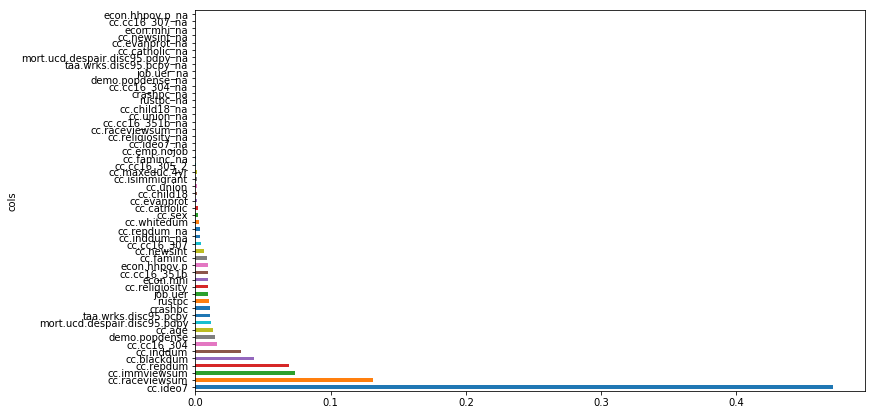

In [41]:
def plot_fi(fi): 
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:]);

As you can see most of the above do not matter, lets see what happens when we only use those that account for >.005 (greater than half a percent)

In [73]:
to_keep=fi[fi.imp>0.008].cols; len(to_keep)
# to_keep

19

# Train a new RandomForest only on important features (drop others)

In [74]:
#create new trn set, keep only columns listed above
trn_keep = trn[to_keep].copy()
tst_keep = tst[to_keep].copy()

In [66]:
m1 = RandomForestRegressor(n_estimators=2000, n_jobs=-1, 
                        oob_score=True, max_features='auto', min_samples_leaf=5)
m1.fit(trn_keep, trn_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [67]:
print_score(m1, trn_keep, trn_y, tst_keep, tst_y )
#[0.1732101326060013, 0.2419867915197795, 0.8791258627822779, 0.7647816350511024, 0.7456946960198437]  all columns
#[0.17700665876025426, 0.24587567779382105, 0.8737690044685158, 0.7571606597054799, 0.7375853110086588] >.005 
#[0.18575200658248822, 0.2495160868663049, 0.860987508681502, 0.7499165190396515, 0.7320435625302746] >.01
#[0.25006557227754617, 0.2478853283763553, 0.7480614603264728, 0.7531747702776621, 0.7236431805106943] >.02

#[0.26964518916289276, 0.265588825604379, 0.7070644017734026, 0.7166602533514237, 0.6910908074614164] >.05

[0.26964518916289276, 0.265588825604379, 0.7070644017734026, 0.7166602533514237, 0.6910908074614164]


In [68]:
preds1 = m1.predict(tst_keep)
preds1 = [0 if x<0.5 else 1 for x in preds1]

eval_accuracy(preds1,tst_y)
#Got 3763 right out of 4089 samples, Accuracy is 92.02739056003912 percent  #>.005

Got 3701 right out of 4089 samples, Accuracy is 90.51112741501589 percent


<B>So accuracy and R**2 drop as you drop columns, but not by much.  Also if you just keep the top 4 columns, your accuracy drops to 90.5% from 92.3%

So what predicts a trump voter?
- cc.ideo7 (by far the biggest) 
- cc.raceviewsum
- cc.immviewsum
- cc.repdum	</b>

# Remove redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [69]:
from scipy.cluster import hierarchy as hc

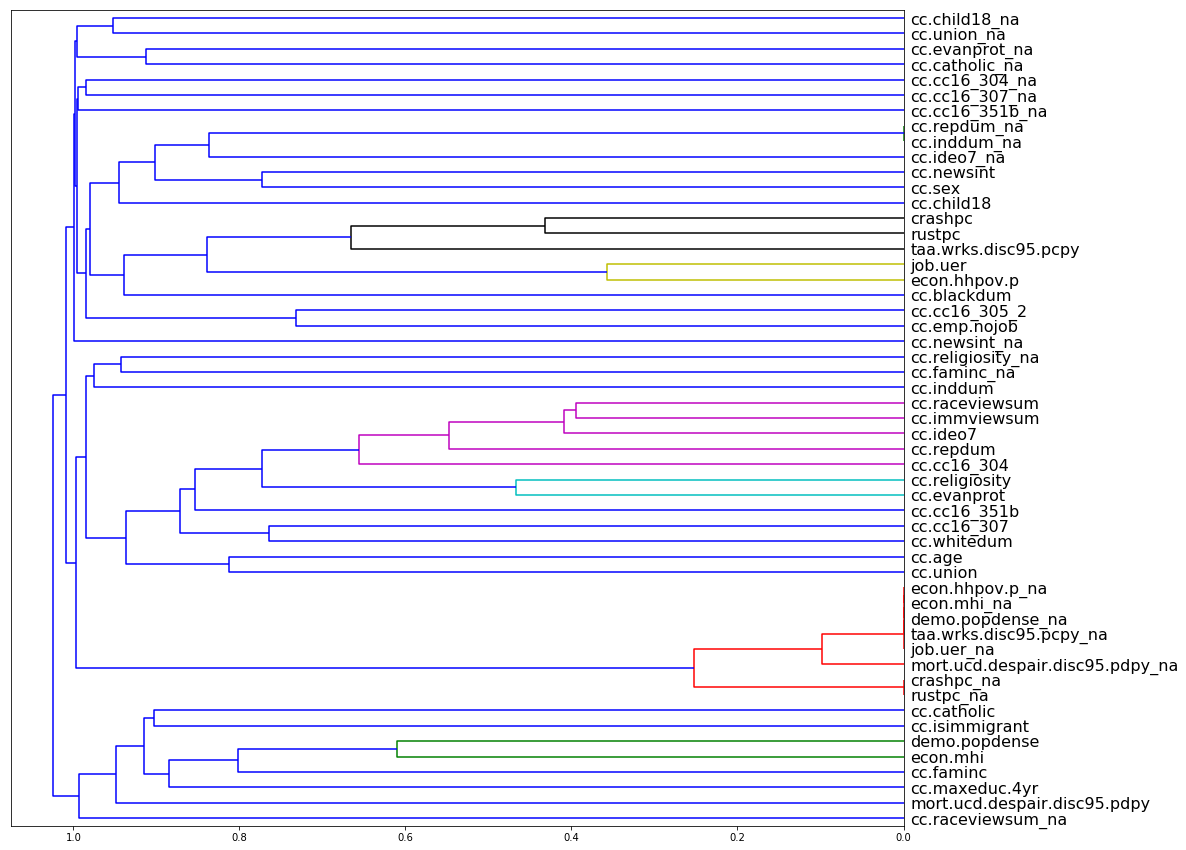

In [77]:
corr = np.round(scipy.stats.spearmanr(trn).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,15))
dendrogram = hc.dendrogram(z, labels=trn.columns, orientation='left', leaf_font_size=16)
plt.show()

Notice the x axis starts at 1 and goes to 0.  If 2 features are linked at or near 0 then they are highly correlated.  Im seeing that for several _na columns.  These columns are added when there is at least 1 row that has a NaN for that column. If a row has an autofilled value for that column then the _na column is set to True, otherwise its false.  My guess is several of these columns have the same values in them.  In any case we could probably remove them an d not affect the models accuracy.

so.. dump cc.repdum_na keep cc.inddumna
dump econ.hhpov.p_na,econ.mhi_na, demo+popdense_na, taa.wrks..._na, keep job.uer_na
dump crash_pc_na keep rustpc_na
or some combo of above.

# Conclusions and Next Steps
This model is 92.2% accurate with no data tweaks

# Scratch

In [ ]:
data = test[0]
data[31]
type(data)
data.shape
tmp=learn.predict(data)
len(tmp)
out,pred,res=tmp

out
pred
res

# len(out)
# len(pred)
len(res)